# Analysis of Audience participant body sway, MusicLab Copenhagen


Generation of plots for Audience Motion paper

In [6]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

In [7]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
%aimport frf

In [8]:
%reload_ext autoreload

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [9]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [10]:
internal_Part = general_loc + 'Participants_internal/'

In [11]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [12]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


In [18]:
concert_times = pd.read_csv(public_time +'Events_Main_Segments.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [19]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
Main_concert_times['Sections']=''
for ev in evord:
    Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev[:4]),'Sections'] = ev

Main_concert_times.iloc[:5,:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,Shorter_tag,sequence,Sections
Datetime,,,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,Claps 0,0,Clapping
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.12,117.08,Speech 1,1,Speech
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,Claps 1,2,Clapping
2021-10-26 17:38:59,-547.16,-547160,Speech MC1,Speech,1090.08,377.52,Speech 2,3,Speech
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,1.05,Claps 1.1,4,Clapping


In [20]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


One of the unfortunate characteristics of the cellphone measurements is their inconsistent sample rates and frequent gaps. Measurements per device were transmitted in 60 s batches, however there were (for as of yet undetermined reasons) often gaps between batches, sometimes of several seconds. These frequent discontinuities complicate how this data can be treated. Some steps taken were necessary compromises because of these measurement issues. There were also discontinuities from participants turning off the app to answer questions (remote participants only) or during intermission. To handle these gaps with care throughout these analyses, we inserted NaN values in any gaps lasting more than a second before resampling the ACC measurements to get Quantity of Motion measures on common timestamp values.

Lastly there was some data loss from phones lossing power or th app being accidentally or incidentally turned off/closed.

The individual participants accelerometer measurements during the concert experiment were resampled to matching timestamps at 50 Hz

In [21]:
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
    print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        trial_dic[part] = pd.Series(index=dt_ct,data=b*5)
    else:
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct

ADQ001
ADQ002
ADQ003
ADQ004
ADQ005
ADQ006
ADQ007
ADQ008
ADQ009
ADQ010
ADQ011
ADQ012
ADQ013
ADQ014
ADQ015
ADQ016
ADQ017
ADQ018
ADQ019
ADQ020
ADQ021
ADQ022
ADQ023


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x

ADQ024
ADQ025
ADQ026
ADQ027
ADQ028
ADQ029
ADQ030
ADQ031
ADQ032
ADQ033
ADQ034
ADQ035
ADQ036
ADQ037
ADQ038
ADQ039
ADQ040
ADQ041
ADQ042
ADQ043
ADQ044
ADQ045
ADQ046
ADQ047
ADQ048
ADQ049
ADQ050
ADQ051
ADQ052
ADQ053
ADQ054
ADQ055
ADQ056
ADQ057
ADQ058
ADQ059
ADQ060
ADQ061
ADQ062
ADQ063
ADQ064
ADQ065
ADQ066
ADR067
ADR068
ADR069
ADR070
ADR071
AEQ077
AEQ078
AEQ079
AEQ080
AEQ081
AEQ082
AEQ083
AEQ084
AEQ085
AEQ086
AEQ087
AEQ088
AEQ089
AER090
BDQ092
BDQ093
BEQ095
BEQ096
BEQ097
BEQ098
BEQ099
BEQ100
BEQ101
BEQ102
BEQ103
BEQ104
BEQ105
BEQ106
BEQ107
BEQ108
BEQ109
BEQ110
BEQ111
BEQ112
BEQ113
BEQ114
BEQ115
BEQ116
BEQ117
BEQ118
BEQ119
BnQ131
BnQ132
BnQ133
103.58879804611206
103.65662217140198


In [22]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


In [23]:
aud_df.index = (ts_ct/1000).round(1)
ori_aud_df = aud_df.copy()
# ori_aud_df.index = (ts_ct/1000).round(1) # convert to seconds from milliseconds


# Scaling, segmentation and preliminary analysis
using 50 Hz sampled measurements.

In [28]:
aud_df.index = dt_ct        
ori_aud_df = aud_df.copy()
ori_aud_df.index = (ts_ct/1000).round(1)


In [29]:
ori_aud_df.iloc[:5,:]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
-1086.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.8,0.740777,0.467856,0.212834,0.101379,0.234912,0.224302,0.486310,0.064859,0.247404,0.237059,...,0.032345,NaN,NaN,NaN,NaN,0.227207,NaN,NaN,NaN,NaN
-1085.7,0.691307,0.179505,0.349901,0.100000,0.249657,0.184666,0.597926,0.055355,0.543207,0.371191,...,0.010653,NaN,NaN,NaN,NaN,0.183257,NaN,NaN,NaN,NaN
-1085.6,0.711500,0.137325,0.154668,0.063158,0.181522,0.134561,0.456580,0.072090,0.082915,1.156659,...,0.017225,NaN,NaN,NaN,NaN,0.140195,NaN,NaN,NaN,NaN


In [131]:
minDur=60

In [132]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.query('Sections==@ev_tag and Event_Duration > @minDur')
    sigs = []
    for i,r in MTs.iterrows():
         sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df.loc[ev_tag,:] = fullset.mean()
df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
Beethoven,0.069311,NaN,0.094418,0.101837,0.07339,0.108468,0.079436,0.086562,0.078947,0.132908,...,0.050851,0.209203,0.106644,0.164509,0.342741,0.182293,NaN,0.084129,0.272131,NaN
Schnittke,NaN,NaN,0.09243,0.143013,0.08211,0.1171,0.071236,0.08482,0.083305,0.106298,...,NaN,0.324734,0.160088,0.174884,0.288465,0.168656,NaN,NaN,0.142764,NaN
Bach,0.056344,0.135229,0.095909,0.124146,0.076237,0.103214,0.072805,0.075133,0.063821,0.103792,...,NaN,NaN,0.161927,NaN,NaN,NaN,0.041645,0.080859,0.044488,0.064046
Folk,0.090395,0.110848,0.12164,0.16044,0.102084,0.103741,0.122425,0.108638,0.077485,0.166454,...,0.13115,NaN,0.31208,1.033047,NaN,NaN,NaN,0.099888,0.068717,0.11593
Survey,0.209239,0.276741,0.138638,0.390651,0.154346,0.20982,0.193861,0.116464,0.160078,0.598902,...,2.63744,0.300593,NaN,0.21808,0.455517,NaN,NaN,0.257953,0.263718,0.225292
Speech,0.163682,0.260689,0.296558,0.231577,0.125858,0.166728,0.116513,0.112045,0.115769,0.330659,...,NaN,0.482708,0.127551,0.716373,NaN,0.259556,0.02373,0.105133,0.465619,0.162762
Clapping,0.903431,1.050359,1.149658,1.383438,0.679812,1.88919,1.528213,1.328942,1.003264,1.406358,...,0.428255,0.739514,0.957739,0.021591,NaN,NaN,NaN,0.331674,0.277735,0.421537


In [133]:
mu = df.loc['Speech',df.columns.str.startswith('A')].median()
#scalling factor, just for simplicity of plotting. 
mu

0.15316226730411814

In [135]:
ev_tags = ['Music']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.query('Event_Type==@ev_tag and Event_Duration > @minDur')
    for i,r in MTs.iterrows():
        if r['Event_Duration']> min_dur:
            sigs = ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:]
            df.loc[r['Shorter_tag'],:] = sigs.mean()

# inhall only,scaled for plotting
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
res2 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)')
res2['Sections'] = 'Music'

# Participant survey responses

Referenced results (demographics and traits) and specific tests and paper plots related to audience motion, performed and percieved.

In [113]:
# pull audience questionnair responses
Quest_text = pd.read_csv(public_Part + 'Surveys_Codebook.csv', delimiter=",", encoding='latin-1')
Quest_df = pd.read_csv(public_Part + 'Surveys_Prepared_Data_Public.csv',sep=',', encoding='latin-1')
Quest_df.set_index(Quest_df['ParticipantCode'],inplace = True,drop = True)
# only want the responses of people with aligned motion measurements
Quest_df = Quest_df.loc[aligned_Part_Codes,:].copy()#.reset_index(drop = True)
HQ_df = Quest_df.loc[Quest_df['ParticipantCode'].str.startswith('A'),:].copy()
RQ_df = Quest_df.loc[Quest_df['ParticipantCode'].str.startswith('B'),:].copy()
Quest_df.iloc[:5,:]

,ParticipantCode,age,gender,musician_status,personal_relation,fan,EC_1,EC_2,EC_3,EC_4,...,changed_behaviour,EC,EC_noTouched,AIMS,KM_Beethoven,KM_Schnittke,KM_Folk,AWE_Beethoven,AWE_Schnittke,AWE_Folk
ParticipantCode,,,,,,,,,,,,,,,,,,,,,
ADQ001,ADQ001,60.0,Woman,Music-loving nonmusician,No_Relation,7.0,4.0,3.0,3.0,2.0,...,NaN,3.714286,3.666667,144,3.6,3.5,4.3,3.833333,4.166667,3.833333
ADQ002,ADQ002,84.0,Man,Music-loving nonmusician,No_Relation,7.0,1.0,5.0,1.0,5.0,...,NaN,1.000000,1.000000,108,3.7,3.6,3.0,4.833333,4.833333,4.166667
ADQ003,ADQ003,46.0,Man,Music-loving nonmusician,No_Relation,7.0,5.0,1.0,4.0,1.0,...,NaN,4.428571,4.333333,127,1.4,1.3,2.9,1.000000,2.833333,1.833333
ADQ004,ADQ004,57.0,Man,Music-loving nonmusician,No_Relation,7.0,2.0,3.0,4.0,2.0,...,NaN,3.714286,3.500000,154,1.9,1.1,3.1,3.500000,4.333333,3.666667
ADQ005,ADQ005,47.0,Man,Serious amateur musician,Relative_Friend,7.0,2.0,3.0,3.0,4.0,...,NaN,2.428571,2.500000,117,1.2,2.8,3.6,3.000000,2.666667,3.500000


# Motion ratings and QoM
Enboxen function of seaborn  
https://vita.had.co.nz/papers/letter-value-plot.html

In [145]:
sub_Q_List=['ParticipantCode',
            'aware_body_Beethoven', 'aware_movement_Beethoven', 'aware_others_moving_Beethoven',
            'aware_body_Schnittke', 'aware_movement_Schnittke', 'aware_others_moving_Schnittke',
            'aware_body_Bach', 'aware_movement_Bach', 'aware_others_moving_Bach', # bach
            'aware_body_Folk', 'aware_movement_Folk', 'aware_others_moving_Folk']

In [146]:
sub_text = Quest_text.loc[Quest_text['ID'].isin(sub_Q_List),:]
sub_text.set_index('ID',drop=True,inplace = True)
# sub_text

In [147]:
sub_Q = Quest_df[sub_Q_List].copy()
sub_H = HQ_df[sub_Q_List].copy()
sub_R = RQ_df[sub_Q_List].copy()

In [148]:
Full_Rels = pd.concat([Sub_Rels,Sub_Rels.rename(columns={'Participant_Code_1':'Participant_Code_2','Participant_Code_2':'Participant_Code_1'})])
# Full_Rels

In [149]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk']
MQoM_df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
MSeenQoM_df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
MaxSeenQoM_df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)

for ev_tag in ev_tags:
    MTs = Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev_tag),:]
    sigs = []
    for i,r in MTs.iterrows():
        if r['Event_Duration']> 60:
             sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    MQoM_df.loc[ev_tag,:] = fullset.mean()/mu
    for part in Full_Rels['Participant_Code_1'].unique():
        neighbours = Full_Rels.loc[Full_Rels['Participant_Code_1'].isin([part]),:]
        seen_neighbours = neighbours.loc[neighbours['Distance'].isin([1.0,2.0]),'Participant_Code_2'].values
        MSeenQoM_df.loc[ev_tag,part] = MQoM_df.loc[ev_tag,seen_neighbours].mean()
        MaxSeenQoM_df.loc[ev_tag,part] = MQoM_df.loc[ev_tag,seen_neighbours].max()  # max if helpful


In [69]:
# reQ
req_Q_List=['ParticipantCode','Music','Stimuli_N','aware_body', 'aware_movement', 'aware_others_moving']
sub_list = ['ParticipantCode','aware_body', 'aware_movement', 'aware_others_moving']
Stimuli_N = {1:'Beethoven',2:'Schnittke',3:'Bach',4:'Folk'}
 
mm_df = pd.DataFrame(columns=['ParticipantCode','Condition','Music','mQoM'])

for stim in Stimuli_N.keys():
    mtag= Stimuli_N[stim]
    A = sub_Q.loc[:,['ParticipantCode','aware_body_'+mtag, 'aware_movement_'+mtag, 'aware_others_moving_'+mtag]].copy()
    A=A.rename(columns={'aware_body_'+mtag:'aware_body', 'aware_movement_'+mtag:'aware_movement','aware_others_moving_'+mtag:'aware_others_moving'})
    A['Music'] = mtag
    A['Stimuli_N'] = stim
    A['mQoM']= MQoM_df.loc[mtag,:]
    A['Motion_seen']= MSeenQoM_df.loc[mtag,:]
    A['Motion_seen_Max']= MaxSeenQoM_df.loc[mtag,:] # max if helpful
    A.loc[A['ParticipantCode'].str.startswith('A'),'Condition'] = 'Hall'
    A.loc[A['ParticipantCode'].str.startswith('B'),'Condition'] = 'Remote'
    mm_df = pd.concat([mm_df,A])


In [70]:
mm_df.to_csv('./data/Participants_Pieces_motion_judgements.csv',index=False)

In [71]:
mm_df = pd.read_csv('./data/Participants_Pieces_motion_judgements.csv')
mm_df

,ParticipantCode,Condition,Music,mQoM,aware_body,aware_movement,aware_others_moving,Stimuli_N,Motion_seen,Motion_seen_Max
0,ADQ001,Hall,Beethoven,0.397257,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,1.0,0.732901,0.823137
1,ADQ002,Hall,Beethoven,NaN,Rarely,Not aware of movement,Not aware of others' movement,1.0,0.467469,0.529199
2,ADQ003,Hall,Beethoven,0.541163,Continuously,Yes and I moved a normal amount,Not aware of others' movement,1.0,0.599071,0.761768
3,ADQ004,Hall,Beethoven,0.583683,Not at all,Yes and I moved less than usual,Not aware of others' movement,1.0,0.550443,0.618796
4,ADQ005,Hall,Beethoven,0.420638,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,1.0,0.323668,0.323668
...,...,...,...,...,...,...,...,...,...,...
455,BEQ118,Remote,Folk,NaN,NaN,NaN,NaN,4.0,NaN,NaN
456,BEQ119,Remote,Folk,NaN,NaN,NaN,NaN,4.0,NaN,NaN
457,BnQ131,Remote,Folk,0.572512,Intermittently,Yes and I moved more than usual,Yes and they moved a normal amount,4.0,NaN,NaN
458,BnQ132,Remote,Folk,0.393856,Rarely,Not aware of movement,Not aware of others' movement,4.0,NaN,NaN


In [72]:
mm_df.columns

Index(['ParticipantCode', 'Condition', 'Music', 'mQoM', 'aware_body',
       'aware_movement', 'aware_others_moving', 'Stimuli_N', 'Motion_seen',
       'Motion_seen_Max'],
      dtype='object')

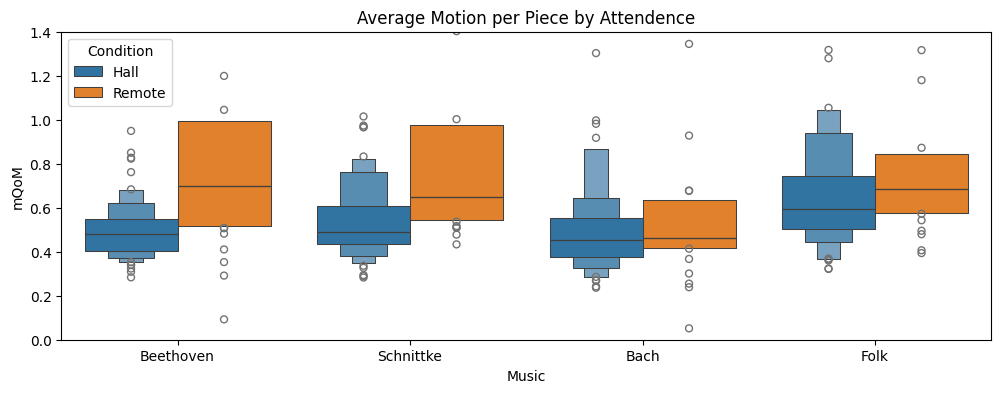

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Condition,3.804843,1,88,3.804843,20.409491,0.000019,NaN,0.188263,NaN,NaN,NaN,NaN
1,Music,1.636062,3,264,0.545354,9.031797,0.000010,0.000256,0.093081,0.674087,False,0.451046,1.114687e-13
2,Interaction,0.990887,3,264,0.330296,5.470140,0.001161,NaN,0.058523,NaN,NaN,NaN,NaN


In [150]:
tag_Q = 'Condition'
tag_m = 'mQoM'
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Hall','Virtual']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df, ax = ax1)
plt.xticks(fontsize=10)
plt.title('Average Motion per Piece by Attendence')
plt.ylim([0,1.4])
# plt.grid()
# plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 196)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='ParticipantCode',data=mm_df)


In [151]:
mm_df_Hall = mm_df.loc[mm_df['Condition'].isin(['Hall']),:]
mm_df_Rem = mm_df.loc[mm_df['Condition'].isin(['Remote']),:]
# less 
mm_df_less = mm_df_Hall.loc[mm_df_Hall['Music'].isin(['Beethoven','Schnittke','Bach']),:]
mm_df_Folk = mm_df_Hall.loc[mm_df_Hall['Music'].isin(['Folk']),:]
# less 
mm_df_less_R = mm_df_Rem.loc[mm_df_Rem['Music'].isin(['Beethoven','Schnittke','Bach']),:]
mm_df_Folk_R = mm_df_Rem.loc[mm_df_Rem['Music'].isin(['Folk']),:]

### Awareness of body

In [153]:
tag_Q = 'aware_body'
tag_m = 'mQoM'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']
print(QuT)

Were you aware of your physical body during this piece?


       Source  ddof1       ddof2         F     p-unc       np2
0  aware_body      3  100.357825  1.304347  0.277249  0.059193


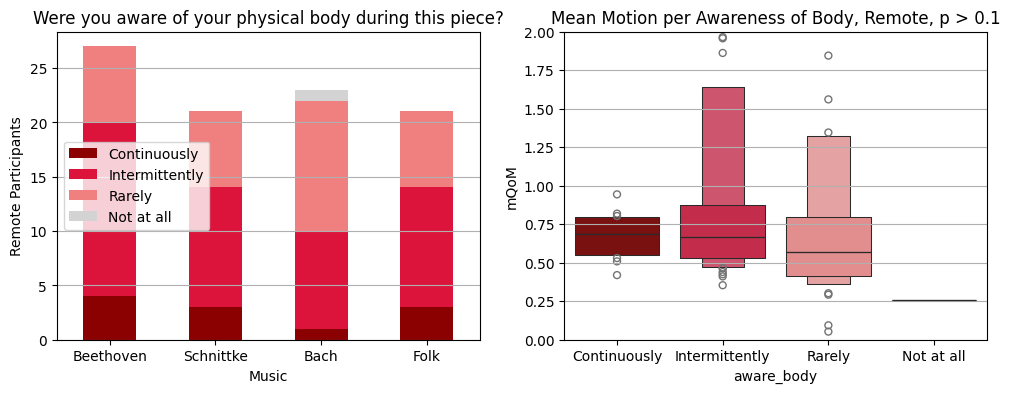

In [154]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_R[tag_Q + '_' + t].value_counts()

f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
ax1.grid(axis='y')
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Remote Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Rem)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m,hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Rem, ax = ax2)
ax2.set_title('Mean Motion per Awareness of Body, Remote, p > 0.1')
ax2.set_ylim([0,2])
ax2.grid(axis='y')
plt.savefig('./plots/body_aware_B_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()

Aware of physical body...
       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      3  83.779233  0.534294  0.660035  0.006529
                A               B   mean(A)   mean(B)      diff        se  \
0    Continuously  Intermittently  0.585112  0.539041  0.046071  0.039443   
1    Continuously      Not at all  0.585112  0.570456  0.014656  0.061420   
2    Continuously          Rarely  0.585112  0.543422  0.041690  0.043555   
3  Intermittently      Not at all  0.539041  0.570456 -0.031415  0.051229   
4  Intermittently          Rarely  0.539041  0.543422 -0.004381  0.027368   
5      Not at all          Rarely  0.570456  0.543422  0.027034  0.054458   

          T          df      pval    hedges  
0  1.168040   52.671390  0.649420  0.238394  
1  0.238618   57.447540  0.995166  0.057914  
2  0.957183   72.910315  0.774002  0.188620  
3 -0.613230   34.046676  0.927166 -0.159152  
4 -0.160076  142.683303  0.998533 -0.022834  
5  0.496420   42.757365  0.959452 

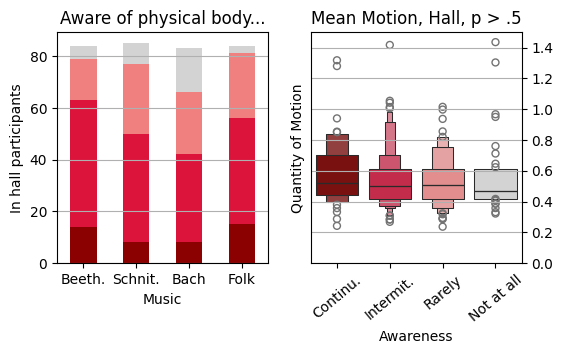

In [159]:
print(QuT)
QuT = 'Aware of physical body...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Continuously','Intermittently','Rarely','Not at all']
short_responses = ['Continu.','Intermit.','Rarely','Not at all']
resp_map = {'Continuously':'Continu.','Intermittently':'Intermit.','Rarely':'Rarely','Not at all':'Not at all'}

my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df.rename(columns=resp_map,inplace=True)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend=False,color = my_pal.values(),ax = ax1)
ax1.grid(axis='y')
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(tracks_tag)
ax1.set_title(QuT)
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')
# fig.legend(loc='center right',ncol=3,fontsize = 8)

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)
print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall))

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ax2.set_xticks([0,1,2,3])
# ax2.set_xticklabels(short_responses,labelrotation='20')
ax2.set_xticklabels(short_responses,rotation=40)
ax2.set_xlabel('Awareness')
ax2.set_ylabel('Quantity of Motion')
ax2.set_title('Mean Motion, Hall, p > .5')
ax2.yaxis.tick_right()
ax2.set_ylim([0,1.5])
ax2.grid(axis='y')

plt.savefig('./plots/body_aware_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
#fig.legend(labels = feats, loc='center right', ncol=3,fontsize = 8)

plt.show()

In [88]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = tracks, columns = sub_H[tag_Q + '_' + tracks[0]].unique())
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df

,Intermittently,Rarely,Continuously,Not at all,NaN
Beethoven,49.0,16.0,14.0,5.0,NaN
Schnittke,42.0,27.0,8.0,8.0,NaN
Bach,34.0,24.0,8.0,17.0,NaN
Folk,41.0,25.0,15.0,3.0,NaN


In [89]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Continuously,Intermittently,0.585112,0.539041,0.046071,0.039443,1.168040,52.671390,0.649420,0.238394
1,Continuously,Not at all,0.585112,0.570456,0.014656,0.061420,0.238618,57.447540,0.995166,0.057914
2,Continuously,Rarely,0.585112,0.543422,0.041690,0.043555,0.957183,72.910315,0.774002,0.188620
3,Intermittently,Not at all,0.539041,0.570456,-0.031415,0.051229,-0.613230,34.046676,0.927166,-0.159152
4,Intermittently,Rarely,0.539041,0.543422,-0.004381,0.027368,-0.160076,142.683303,0.998533,-0.022834
5,Not at all,Rarely,0.570456,0.543422,0.027034,0.054458,0.496420,42.757365,0.959452,0.117673


       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      3  65.177414  0.514011  0.674063  0.015448
       Source  ddof1     ddof2         F     p-unc       np2
0  aware_body      3  9.222928  0.744481  0.551536  0.034897


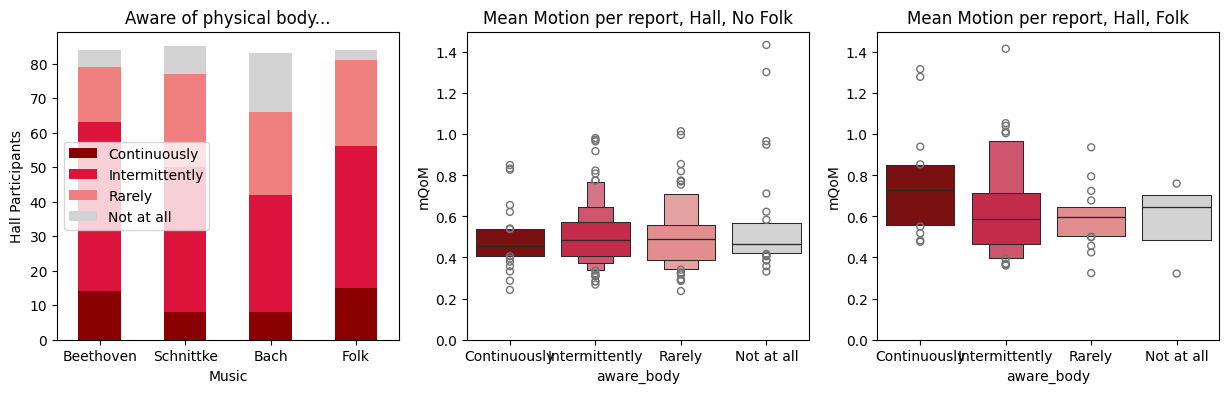

In [90]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
# ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, hue = tag_Q, legend=False,palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
ax2.set_title('Mean Motion per report, Hall, No Folk')
ax2.set_ylim([0,1.5])
# ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, hue = tag_Q, legend=False, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
ax3.set_title('Mean Motion per report, Hall, Folk')
ax3.set_ylim([0,1.5])
# ax3.grid()
plt.savefig('./plots/body_aware_A_R_qom_less.png',bbox_inches = 'tight',dpi = 196)
plt.show()

### Amount of motion, Normative

In [91]:
tag_Q = 'aware_movement'
tag_m = 'mQoM'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']
print(QuT)
QuT = 'Relative to your own usual behaviour...' 


Were you aware of your own physical movement during this piece? If so, how much did you move relative to your own usual behaviour at this kind of concert?


In [92]:
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='ParticipantCode',data=mm_df_Hall)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_movement,0.589587,3,8,0.196529,1.947278,0.200614,NaN,0.422042,NaN,NaN,NaN,NaN
1,Music,0.217975,3,24,0.072658,11.688065,0.000065,0.010944,0.593662,0.469263,False,0.14577,0.002292
2,Interaction,0.186901,9,24,0.020767,3.340612,0.008728,NaN,0.556094,NaN,NaN,NaN,NaN


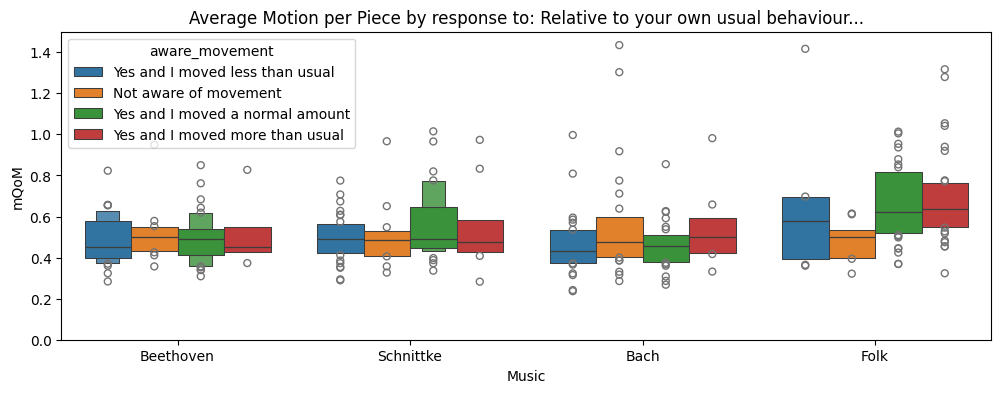

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_movement,0.589587,3,8,0.196529,1.947278,0.200614,NaN,0.422042,NaN,NaN,NaN,NaN
1,Music,0.217975,3,24,0.072658,11.688065,0.000065,0.010944,0.593662,0.469263,False,0.14577,0.002292
2,Interaction,0.186901,9,24,0.020767,3.340612,0.008728,NaN,0.556094,NaN,NaN,NaN,NaN


In [93]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}


f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(fontsize=10) #rotation='20',ha = 'right',
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,1.5])
# plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='ParticipantCode',data=mm_df_Hall)


In [94]:
hall_trimed = mm_df_Hall.loc[mm_df_Hall['mQoM'].notna(),:].copy()
rem_trimed = mm_df_Rem.loc[mm_df_Rem['mQoM'].notna(),:].copy()
X = hall_trimed.loc[:,'mQoM']
Y = rem_trimed.loc[:,'mQoM']
print([X.mean(),X.std()])
print([Y.mean(),Y.std()])
#https://vulstats.ucsd.edu/t-tests.html#summary-of-tests-for-the-mean-and-effect-sizes
s2x = am.sampVar(X)
s2y = am.sampVar(Y)
df = (((s2x/len(X))+(s2y/len(Y)))**2)/(((s2x**2)/((len(X)**2)*(len(X)-1)))+((s2y**2)/((len(Y)**2)*(len(Y)-1))))
print('degrees of freedom: ' + str(df))
sp.stats.ttest_ind(X,Y, equal_var=False)

[0.5483132332152029, 0.20523821337354234]
[0.8649116487337001, 0.7473197621239587]
degrees of freedom: 103.76368880682232


TtestResult(statistic=-4.186781346001761, pvalue=5.945923210183196e-05, df=103.76368880682232)

In [95]:
pg.ttest(X,Y)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.186781,103.763689,two-sided,0.000059,"[-0.47, -0.17]",0.777996,485.122,0.999999


           Source  ddof1       ddof2         F     p-unc       np2
0  aware_movement      3  130.642006  4.747926  0.003552  0.046826


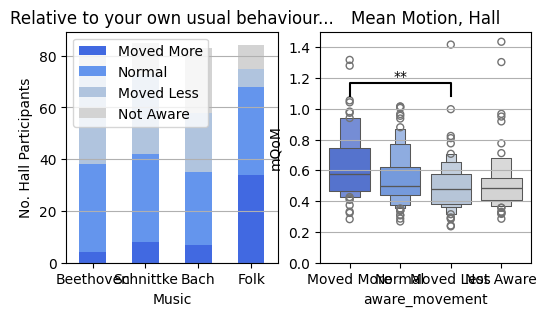

In [97]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid(axis='y')
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall) 
print(aov)
sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses)

ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax2.set_title('Mean Motion, Hall')
ax2.set_ylim([0,1.5])
ax2.grid(axis='y')
plt.savefig('./plots/body_move_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()


Relative to your own usual behaviour...
           Source  ddof1     ddof2         F     p-unc       np2
0  aware_movement      3  64.17205  1.147443  0.336795  0.017263
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.544200   
1            Not aware of movement  Yes and I moved less than usual  0.544200   
2            Not aware of movement  Yes and I moved more than usual  0.544200   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.512209   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.512209   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.486623   

    mean(B)      diff        se         T          df      pval    hedges  
0  0.512209  0.031992  0.039460  0.810741   59.142804  0.849144  0.173956  
1  0.486623  0.057577  0.039339  1.463619   58.398000  0.465748  0.317927  
2  0.544104  0.000097  0.060119  0

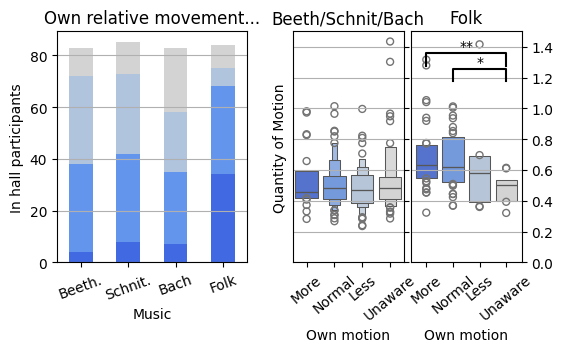

In [98]:
print(QuT)
QuT = 'Own relative movement...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['More','Normal','Less','Unaware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

fig = plt.figure(figsize=(6,3))
gridspec.GridSpec(1,4)

# large subplot
ax1 = plt.subplot2grid((1,12), (0,0), colspan=5, rowspan=1)

#f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1,legend=False)
#ax1.legend(loc="best")
ax1.grid(axis='y')
#ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticklabels(tracks_tag,rotation=20)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)
ax2 = plt.subplot2grid((1,12), (0,6), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
#ax2.set_title('Mean QoM, Hall, p>.3')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_less)
print(ac)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax2.set_ylim([0,1.5])
ax2.yaxis.tick_right()
ax2.set_yticklabels([])
ax2.set_ylabel('Quantity of Motion')

ax2.set_xlabel('Own motion')
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses,rotation=40)
ax2.set_title('Beeth/Schnit/Bach')
ax2.grid(axis='y')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)
ax3 = plt.subplot2grid((1,12), (0,9), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
#ax3.set_title('Mean QoM, Hall, p<.05')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(ac)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [1.2,1.1,1.0,0.9], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax3.set_xticks([0,1,2,3])
ax3.set_xticklabels(short_responses,rotation=40)
ax3.set_ylim([0,1.5])
ax3.set_ylabel('')
ax3.set_xlabel('Own motion')
ax3.yaxis.tick_right()
ax3.set_title('Folk')
ax3.grid(axis='y')
plt.savefig('./Plots/body_move_A_R_qom_less.png',bbox_inches = 'tight',dpi = 196)

plt.show()



In [99]:
sub_V = sub_Q.loc[sub_Q['ParticipantCode'].str.startswith('B'),:].copy()

           Source  ddof1      ddof2        F     p-unc       np2
0  aware_movement      3  32.732681  2.00647  0.132332  0.073698
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.575744   
1            Not aware of movement  Yes and I moved less than usual  0.575744   
2            Not aware of movement  Yes and I moved more than usual  0.575744   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.765930   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.765930   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.862046   

    mean(B)      diff        se         T         df      pval    hedges  
0  0.765930 -0.190186  0.133309 -1.426663  41.082583  0.490390 -0.352136  
1  0.862046 -0.286303  0.146399 -1.955631  35.929072  0.223722 -0.601589  
2  1.011169 -0.435425  0.210212 -2.071359  15.385060  0.205894 -0.855989  
3 

<ipython-input-100-b22e72af04bf>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(short_responses)
<ipython-input-100-b22e72af04bf>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(short_responses,rotation=20)


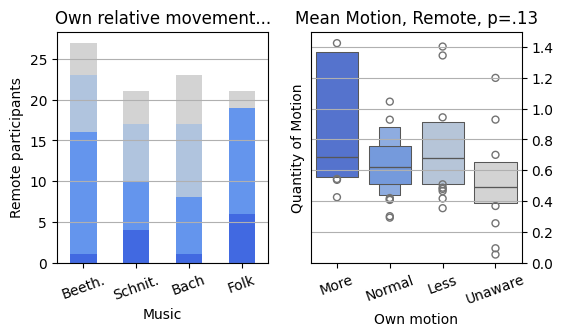

In [100]:
# tracks = ['Beethoven','Schnittke','Bach','Folk']
# response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
# short_responses = ['Moved More','Normal','Moved Less','Not Aware']
# my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_V[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend = False, color = my_pal.values(),ax = ax1)
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
ax1.set_ylabel('Remote participants')
ax1.set_xlabel('Music')
ax1.set_xticklabels(tracks_tag,rotation=20)
ax1.grid(axis='y')
aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Rem) 
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Rem, ax = ax2)
ax2.set_xticklabels(short_responses)
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Rem)
print(ac)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [1.3,1.2,1.0,0.9], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax2.set_xticklabels(short_responses,rotation=20)
ax2.yaxis.tick_right()
ax2.set_xlabel('Own motion')
ax2.set_ylabel('Quantity of Motion')
ax2.set_title('Mean Motion, Remote, p=.13')
ax2.set_ylim([0,1.5])
ax2.grid(axis='y')
plt.savefig('./Plots/body_move_B_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()


## Amount of others' motion, normative

In [101]:
tag_Q = 'aware_others_moving'
tag_m = 'Motion_seen'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']

ID
aware_others_moving_Beethoven    Were you aware of others in the audience movin...
aware_others_moving_Schnittke    Were you aware of others in the audience movin...
aware_others_moving_Bach         Were you aware of others in the audience movin...
aware_others_moving_Folk         Were you aware of others in the audience movin...
Name: English_Q, dtype: object

In [102]:
print(QuT)
QuT = 'How were others moving...' 

Were you aware of others in the audience moving during the piece? If so, how much were they moving relative to the usual behaviour you observe at this kind of concert?


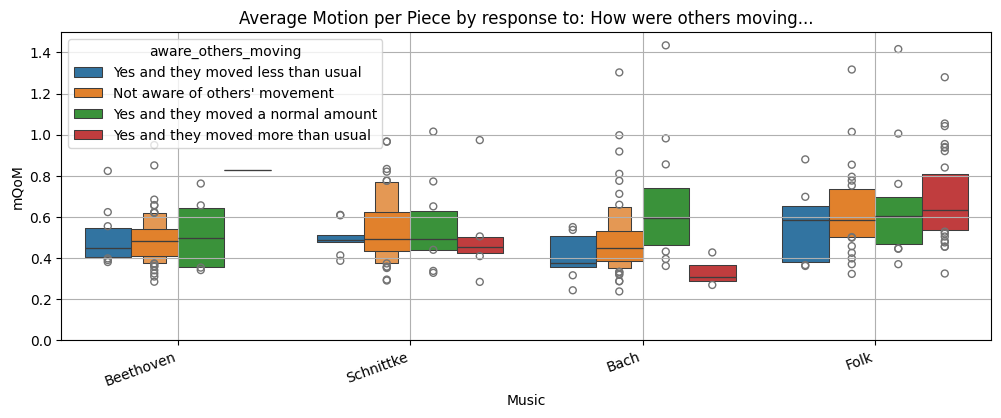

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_others_moving,0.224257,2,21,0.112128,0.627469,0.543657,NaN,0.056389,NaN,NaN,NaN,NaN
1,Music,0.547762,3,63,0.182587,8.043824,0.000128,0.004555,0.276955,0.494,False,0.159264,1.635830e-07
2,Interaction,0.267872,6,63,0.044645,1.966833,0.083795,NaN,0.157765,NaN,NaN,NaN,NaN


In [103]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
sns.boxenplot(x = 'Music',y = 'mQoM', hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(rotation=20,ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,1.5])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv='mQoM',within = 'Music',between = tag_Q,subject='ParticipantCode',data=mm_df_Hall)


In [104]:
sub_H[tag_Q + '_' + t].value_counts()

aware_others_moving_Folk
Yes and they moved more than usual    34
Not aware of others' movement         27
Yes and they moved a normal amount    15
Yes and they moved less than usual     7
Name: count, dtype: int64

                Source  ddof1      ddof2          F     p-unc       np2
0  aware_others_moving      3  89.567777  10.869167  0.000004  0.131509
                                    A                                   B  \
0       Not aware of others' movement  Yes and they moved a normal amount   
1       Not aware of others' movement  Yes and they moved less than usual   
2       Not aware of others' movement  Yes and they moved more than usual   
3  Yes and they moved a normal amount  Yes and they moved less than usual   
4  Yes and they moved a normal amount  Yes and they moved more than usual   
5  Yes and they moved less than usual  Yes and they moved more than usual   

    mean(A)   mean(B)      diff        se         T         df      pval  \
0  0.504010  0.543281 -0.039271  0.022163 -1.771935  59.887431  0.296823   
1  0.504010  0.498950  0.005060  0.018018  0.280814  58.810615  0.992191   
2  0.504010  0.635922 -0.131912  0.023993 -5.497972  55.032316  0.000006   
3  0.543281 

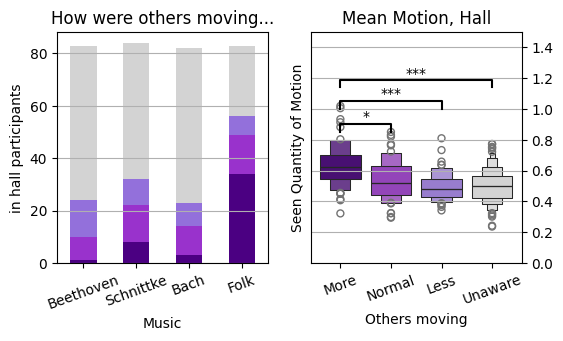

In [107]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']
response_order = ['Yes and they moved more than usual','Yes and they moved a normal amount','Yes and they moved less than usual',"Not aware of others' movement"]
my_pal = {'Yes and they moved more than usual':'indigo','Yes and they moved a normal amount':'darkorchid','Yes and they moved less than usual':'mediumpurple',"Not aware of others' movement":'lightgrey'}
short_responses = ['More','Normal','Less','Unaware']
tag_m = 'Motion_seen'

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and they moved more than usual':'Moved More','Yes and they moved a normal amount':'Normal','Yes and they moved less than usual':'Moved Less',"Not aware of others' movement":'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),legend=False,ax = ax1)
#ax1.legend()
ax1.grid(axis='y')
#ax1.tick_params(axis='x',labelrotation=20)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('in hall participants')
ax1.set_xlabel('Music')
ax1.set_xticklabels(tracks,rotation=20)

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m,hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(ac)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [0.8,0.8,0.95,1.1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=3)

ax2.set_ylabel('Seen Quantity of Motion')
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses,rotation=20)
ax2.yaxis.tick_right()
ax2.set_xlabel('Others moving')
ax2.set_title('Mean Motion, Hall')
ax2.set_ylim([0,1.5])
ax2.grid(axis='y')
plt.savefig('./Plots/others_move_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()